In [1]:
from init import *
import salem
from spatial import RegularGrid
from scipy.stats import linregress

autotime loaded.
autotime loaded.
black loaded.
black loaded.
time: 1.56 s


<IPython.core.display.Javascript object>

In [2]:
months = {"JF": [2, 3], "MAM": [3, 4, 5], "JJAS": [6, 7, 8, 9], "OND": [10, 11, 12]}
seasons = {
    "JF": "WINTER",
    "MAM": "PRE-MONSOON",
    "JJAS": "SUMMER",
    "OND": "POST-MONSOON",
    "Annual": "ANNUAL",
}
periods = ["Annual", "JF", "JJAS", "MAM", "OND"]

time: 757 µs


<IPython.core.display.Javascript object>

In [3]:
dx = pd.read_excel(
    "/home/pankaj/phd/code/practice/sur/data/Rainfall_Data_Tripura_1986-2019_Final.xlsx",
    parse_date=["Date"],
).set_index("Date")

ds1 = (
    pd.read_excel("/home/pankaj/phd/code/practice/sur/data/Stn_code_n_lat_lon.xlsx")
    .set_index("Station_Code")
    .sort_index()
)


ds2 = pd.DataFrame(index=ds1.index, columns=periods)

for period in periods:
    if period == "Annual":
        df = dx.resample("A").mean()
    else:
        df = dx.resample("M").mean()
        df = df[np.isin(df.index.month, months[period])].resample("A").mean()

    for station in df.columns:
        ds2.loc[station, period] = linregress(df.index.year, df[station])[0]

ds = pd.concat([ds1, ds2], axis=1)
# ds

/home/pankaj/.local/Anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/pankaj/.local/Anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


time: 1.51 s


<IPython.core.display.Javascript object>

In [4]:
shp = gpd.read_file(
    "/home/pankaj/phd/code/practice/sur/data/shapefiles/tripura.shp"
).to_crs("EPSG:4326")
xi = np.arange(22.86, 24.52, 0.01)
yi = np.arange(91.12, 92.38, 0.01)
print(xi.shape, yi.shape)

(166,) (126,)
time: 21.3 ms


<IPython.core.display.Javascript object>

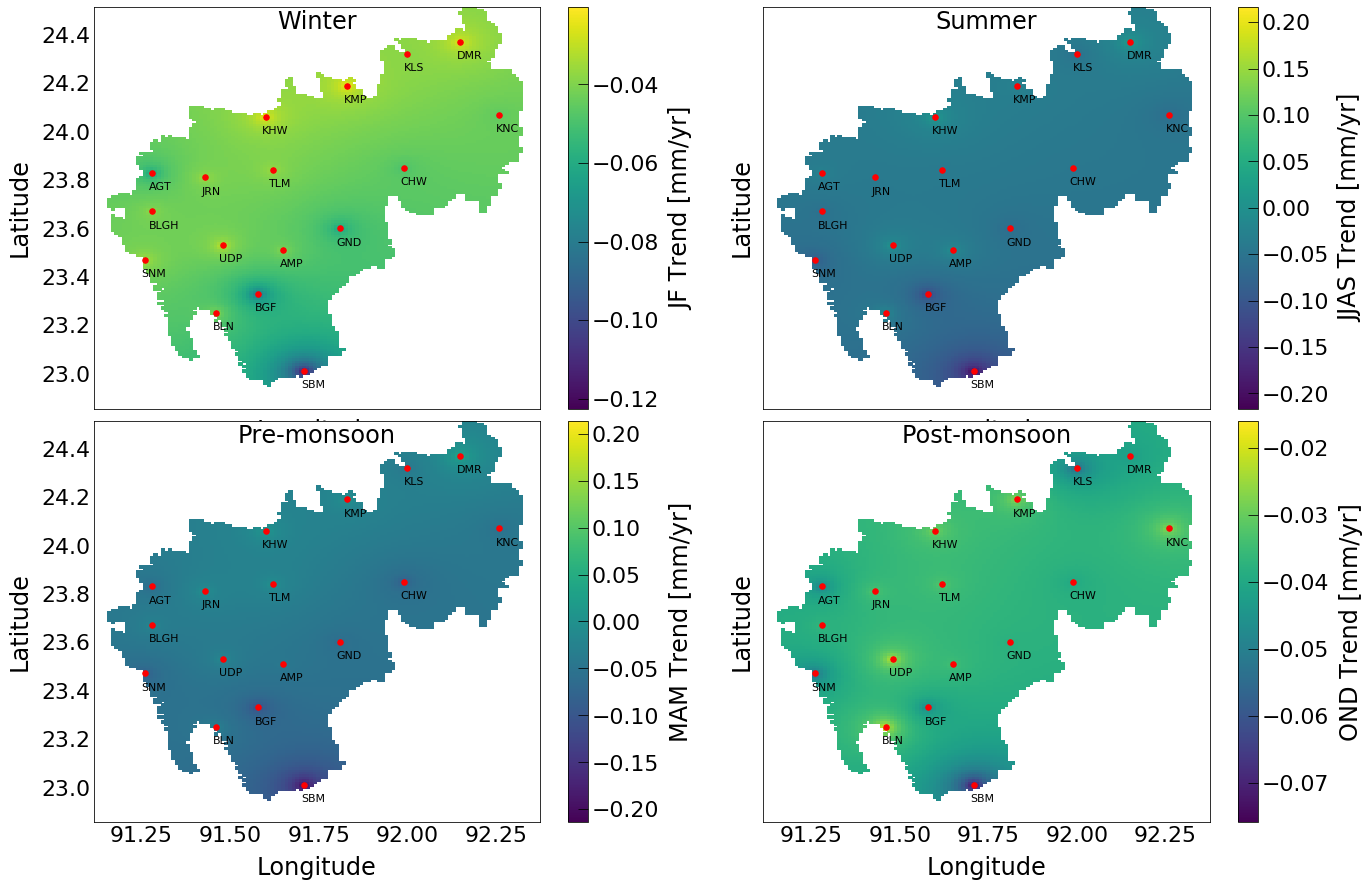

time: 1.86 s


<IPython.core.display.Javascript object>

In [5]:
mn = []
mx = []

x = ds.Lat.values
y = ds.Lon.values
levels = np.linspace(-0.2, 0.1, 30)
fig, axes = plt.subplots(2, 2, figsize=(22, 15), sharex=True, sharey=True)
axes = axes.flatten()
for ax, column in zip(axes, ds2.columns[1:]):
    reg = RegularGrid(ds.Lon.values, ds.Lat.values, ds[column].values)
    zi = reg.interpolate(yi, xi, method="idw")
    zi = xr.DataArray(zi, coords=[xi, yi], dims=["Latitude", "Longitude"])

    zi = zi.salem.roi(shape=shp)  # .T
    zi.attrs = {"long_name": "%s Trend [mm/yr]" % column}

    mn.append(zi.min().values)
    mx.append(zi.max().values)

    zi.plot(ax=ax, cmap="viridis")
    ax.scatter(y, x, s=30, color="r")
    ax.minorticks_on()
    # ax.axis('off')
    ax.set_title(seasons[column].capitalize(), y=0.93)

    for i, idx in enumerate(ds1.index):
        ax.annotate(
            idx,
            xy=(ds1.Lon[i], ds1.Lat[i]),
            xytext=(ds1.Lon[i] - 0.01, ds1.Lat[i] - 0.07),
            fontsize=11,
        )

for ax in axes:
    ax.tick_params(
        axis="both", which="major", right=False, top=False, bottom=False, left=False
    )
    ax.tick_params(
        axis="both", which="minor", right=False, top=False, bottom=False, left=False
    )
plt.subplots_adjust(hspace=0.03)
plt.show()